In [5]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam, l as l_gam,f as f_gam, LinearGAM,LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,degrees_of_freedom,plot as plot_gam,anova as anova_gam)


In [8]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [10]:
poly_age = MS([poly('age',degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [11]:
age_grid = np.linspace(age.min(),age.max(),100)
age_df = pd.DataFrame({'age': age_grid})

In [24]:
def plot_wage_fit(age_df,basis,title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y,X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = plt.subplots()
    ax.scatter(age, y, facecolor = 'gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title,fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    return ax

<Axes: title={'center': 'Degree 4 Polynomial'}, xlabel='Age', ylabel='Wage'>

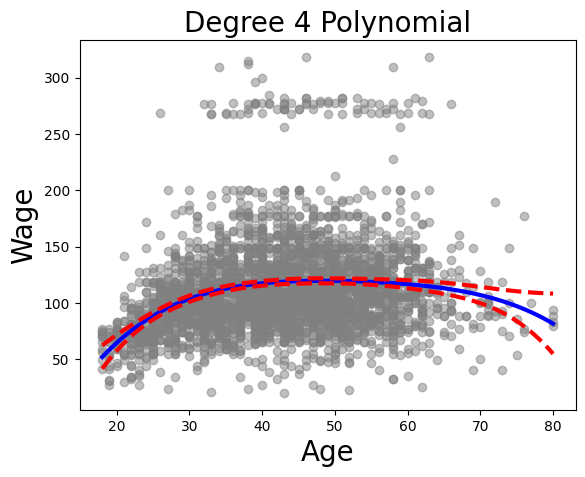

In [25]:
plot_wage_fit(age_df,poly_age,'Degree 4 Polynomial')

In [28]:
models = [MS([poly('age',degree=d)]) for d in range(1,6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y,X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [36]:
models = [MS(['education', poly('age',degree=d)]) for d in range(1,4)]
XEs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y,X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [38]:
X = poly_age.transform(Wage)
high_earn = Wage['High_earn'] = y > 250
glm = sm.GLM(y >250,X,family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [39]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

Text(0, 0.5, 'P(Wage > 250)')

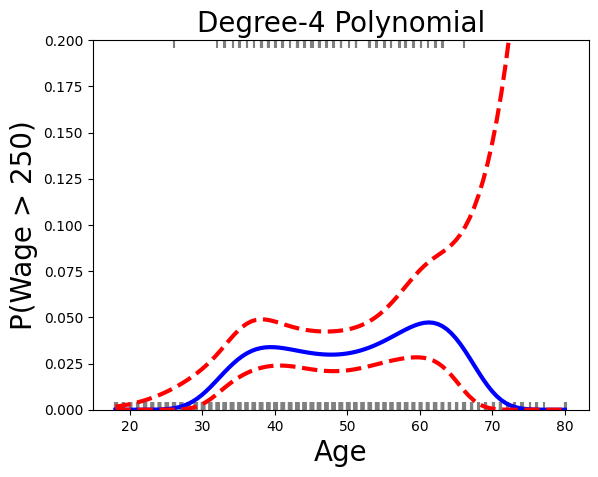

In [47]:
fig, ax = plt.subplots()
rng = np.random.default_rng(0)
ax.scatter(age + 0.2*rng.uniform(size=y.shape[0]),np.where(high_earn,0.198,0.002),fc='gray',marker='|')
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
    ax.plot(age_df.values,val,ls,linewidth=3)
ax.set_title('Degree-4 Polynomial',fontsize=20)
ax.set_xlabel('Age',fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)',fontsize=20)


In [49]:
cut_age = pd.qcut(age,4)
summarize(sm.OLS(y,pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [51]:
# Splines using ISLP actually from scipy interpolate

bs_ = BSpline(internal_knots=[25,40,60],intercept=True).fit(age)
bs_age =bs_.transform(age)
bs_age.shape

(3000, 7)

In [52]:
bs_age = MS([bs('age',internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y,Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [53]:
ns_age = MS([ns('age',df=5)]).fit(Wage)
M_ns = sm.OLS(y,ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


<Axes: title={'center': 'Natural Spline, df=5'}, xlabel='Age', ylabel='Wage'>

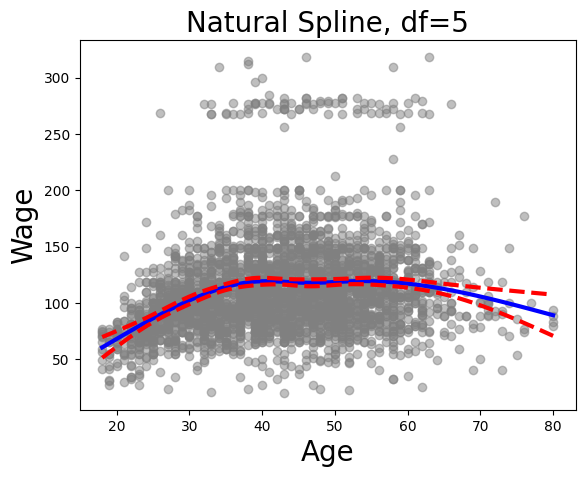

In [54]:
plot_wage_fit(age_df,ns_age,'Natural Spline, df=5')

<Axes: title={'center': 'Basis Spline, df=5'}, xlabel='Age', ylabel='Wage'>

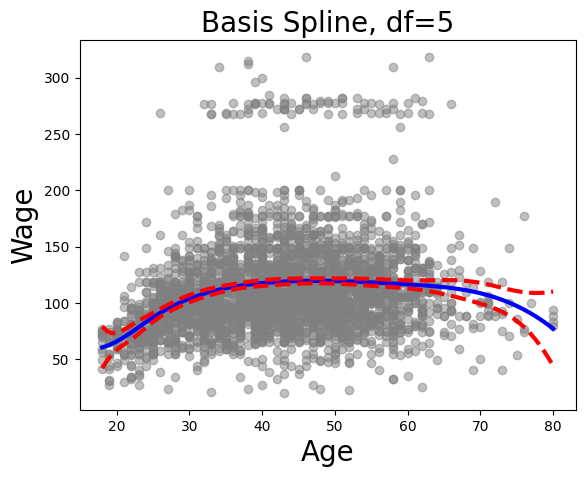

In [56]:
plot_wage_fit(age_df,bs_age,'Basis Spline, df=5')

In [58]:
# Smoothing and GAM - seems like the pygam version is giving us some trouble
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0,lam=0.6))
gam.fit(X_age,y)

C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pygam\pygam.py:225: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pygam\pygam.py:276: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if self.terms is 'auto':
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pygam\pygam.py:225: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pygam\pygam.py:276: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if self.terms is 'auto':
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pygam\pygam.py:225: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
C

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [61]:
#Additive models
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),ns_year.transform(Wage['year']),pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y,X_bh).fit()

Text(0.5, 1.0, 'Partial Dependence of Age on Wage')

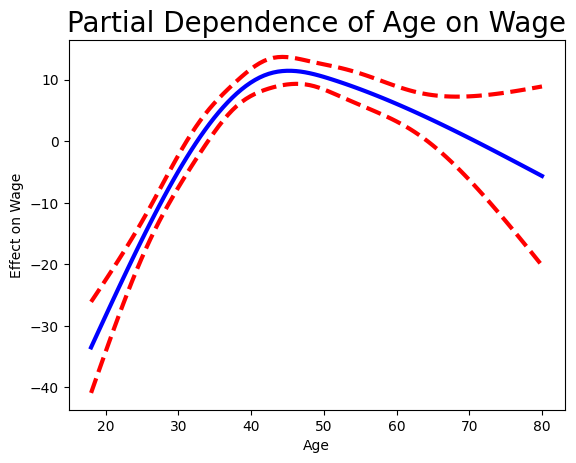

In [71]:
age_grid = np.linspace(age.min(),age.max(),100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

fig,ax = plt.subplots()
ax.plot(age_grid, partial_age,'b',linewidth=3)
ax.plot(age_grid,bounds_age[:,0],'r--',linewidth=3)
ax.plot(age_grid,bounds_age[:,1],'r--',linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial Dependence of Age on Wage',fontsize=20)

Text(0.5, 1.0, 'Partial Dependence of Year on Wage')

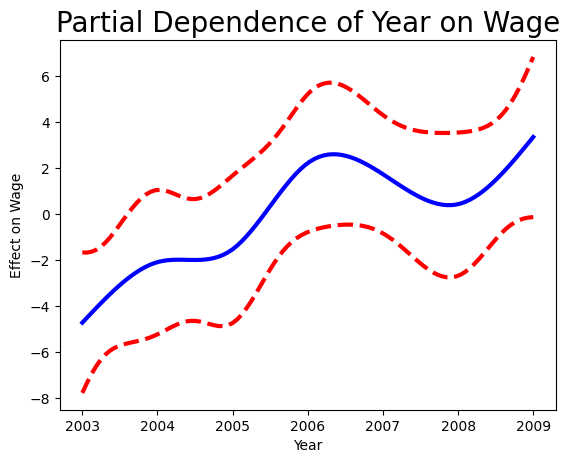

In [75]:
year_grid = np.linspace(Wage['year'].min(),Wage['year'].max(),100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center

fig,ax = plt.subplots()
ax.plot(year_grid, partial_year,'b',linewidth=3)
ax.plot(year_grid,bounds_year[:,0],'r--',linewidth=3)
ax.plot(year_grid,bounds_year[:,1],'r--',linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial Dependence of Year on Wage',fontsize=20)

In [ ]:
# Rest of examples require pygam